### To Do for B.2 -
1. Write a function to load and process a dataset with multiple features with the following requirements:
    a. This function will allow you to specify the start date and the end date for the whole dataset as inputs.

    b. This function will allow you to deal with the NaN issue in the data.

    c. This function will also allow you to use different methods to split the data into train/test data; e.g. you can split it according to some specified ratio of train/test and you can specify to split it by date or randomly.

    d. This function will have the option to allow you to store the downloaded data on your local machine for future uses and to load the data locally to save time.
    
    e. This function will also allow you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

The goal for this task is to just process the data, NOT to train the model aswell.

### Imports

In [1]:
import mplfinance as flpt
from bqplot import pyplot as plt
import bqplot as bq

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

import yfinance as yf



### Setting Data Parameters

In [2]:

company_ticker = "AMZN"

# Specification of start and end date for both train and test sets
# This means that at some point we need to split the dataset
start_date = '2018-01-01'
end_date = '2024-01-01'

NaNHandler = "drop" # Determines how NaN data is handled. Can be "drop", "fill_mean", "fill_median", or "fill_ffill"

test_size = 0.25 # e.g. this would be that 75% of the available data is being used for the train set and 25% is being used for the test set.

# If false the data will be randomly split
split_by_date = True

feature_column = ["Open", "Adj Close", "Volume", "High", "Close", "Low"] # Can be set to "Adj Close", "Volume", "Open", "High", or "Low"

# Scalar is used to normalize data to a specific range (In this code, it normalizes the data to between 0 and 1)
scale = True


### Loading Data from Yahoo Finance or Local File

In [3]:
def load_or_save_data(company_ticker, start_date, end_date, base_dir="data"):
    ###
    # Loads the dataset for the input company and range.
    # If the dataset is not available locally, it downloads the data and saves it as a CSV file.
    # Parameters:
    # - company_ticker: ticker of the company (e.g., "AMZN")
    # - start_date: the start date for the dataset in 'YYYY-MM-DD' format
    # - end_date: the end date for the dataset in 'YYYY-MM-DD' format
    # - base_dir: the base directory where the data will be saved, default is set to "data"
    # Returns:
    # - data: pandas DF, the loaded dataset with the specified features
    ###

    # Generate the save path based on ticker and date range
    filename = f"{company_ticker}_{start_date}_to_{end_date}.csv"
    save_path = os.path.join(base_dir, filename)
    
    # Check if the file already exists
    if os.path.exists(save_path):
        # Load the dataset from the local file
        data = pd.read_csv(save_path, index_col=0, parse_dates=True)
        print(f"Data loaded from local file: {save_path}")
    else:
        # If the file doesn't exist, download the data
        data = yf.download(company_ticker, start=start_date, end=end_date)
        
        # Make sure the base directory exists
        os.makedirs(base_dir, exist_ok=True)
        
        # Save the dataset locally
        data.to_csv(save_path)
        print(f"Data downloaded and saved locally to: {save_path}")
    
    return data

### Handling NaN values in dataset

In [4]:
def handle_nan(data, method='drop'):
    ###
    # Handles NaN values in the dataset based on the specified method.
    # Parameters:
    # - data: pandas Dataframe
    # - method: str, how to handle NaN values. Options are 'drop', 'fill_mean', 'fill_median', 'fill_ffill'.
    # Drop removes all NaN data from the dataset.
    # Mean replaces the NaN data with the mean average of all the data 
    # Mediam replaces the NaN data with the median average of all the data 
    # FFill sets the NaN data to the most recent valid data
    # Returns:
    # - data: pandas Dataframe, the dataset with NaN values handled
    ###


    if method == 'drop':
        data = data.dropna()
    elif method == 'fill_mean':
        data = data.fillna(data.mean())
    elif method == 'fill_median':
        data = data.fillna(data.median())
    elif method == 'fill_ffill':
        data = data.fillna(method='ffill')
    else:
        raise ValueError("Choose from 'drop', 'fill_mean', 'fill_median', 'fill_ffill'.")
    
    return data

### Splitting Data

In [5]:
def split_data(data, test_size=0.25, split_by_date=True, date_column='Date'):

    ###
    # Splits the dataset into training and testing sets based on the specified methods.
    # Parameters:
    # - data: pandas datadframe, the dataset to split
    # - test_size: float, the amount of the dataset to include in the test split (default is 0.25)
    # - split_by_date: bool, split the data by date (True) or randomly (False). If false, the data is split using sklearns train_test_split method
    # - date_column: str, the name of the date column to use for date-based splitting (only needed if split_by_date=True)
    # Returns:
    # - train_data: training set as a pandas dataframe
    # - test_data: testing set as a pandas dataframe
    #
    #
    ###

    if split_by_date:
        # Sort data by date
        data = data.sort_values(by=date_column)
        
        # Determine the split index
        split_index = int(len(data) * (1 - test_size))
        
        # Split the data
        train_data = data.iloc[:split_index]
        test_data = data.iloc[split_index:]
    else:
        # Randomly split the data using sklearn's train_test_split
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=True, random_state=180)
    
    return train_data, test_data


### Scale Data

In [6]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data, feature_columns):
    ###
    # Scales the specified feature columns in the dataset using MinMaxScaler and stores the scalers.
    # Parameters:
    # - data: pandas dataframe, the dataset to scale
    # - feature_columns: list, a list of feature columns to scale (e.g., ["Adj Close"])
    # Returns:
    # - scaled_data: pandas dataframe, the dataset with scaled feature columns
    # - scalers: dict, a dictionary of scalers used to scale the feature columns
    ###
    scalers = {}
    scaled_data = data.copy()
    
    # scale data in specified feature columns
    for feature in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data[feature] = scaler.fit_transform(scaled_data[[feature]])
        scalers[feature] = scaler  # Store the scaler for future access
    
    return scaled_data, scalers

### Using functionalities with parameters

In [7]:
# Load the data
data = load_or_save_data(company_ticker, start_date, end_date)

# Handle NaNs
data = handle_nan(data, NaNHandler)

# Split the data 
train_data, test_data = split_data(data, test_size, split_by_date)

# Scale the data
scaled_train_data, scalers = scale_data(train_data, feature_column)

# Show data
print(train_data.head())
print(scaled_train_data.head())

Data loaded from local file: data/AMZN_2018-01-01_to_2024-01-01.csv
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  58.599998  59.500000  58.525501  59.450500  59.450500  53890000
2018-01-03  59.415001  60.274502  59.415001  60.209999  60.209999  62176000
2018-01-04  60.250000  60.793499  60.233002  60.479500  60.479500  60442000
2018-01-05  60.875500  61.457001  60.500000  61.457001  61.457001  70894000
2018-01-08  61.799999  62.653999  61.601501  62.343498  62.343498  85590000
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2018-01-02  0.000000  0.000000  0.000000  0.000000   0.000000  0.123465
2018-01-03  0.006337  0.005997  0.007042  0.005975   0.005975  0.151675
2018-01-04  0.012830  0.010015  0.013518  0.008095   0.008095  0.145771
2018-01-05  0.017694  0.015152  0.015632

### Data Aggregation

In [8]:
def aggregate_data(data, n_days=1):
    if n_days > 1:
        data_resampled = data.resample(f'{n_days}D').agg({
            'Open': 'first', # Set open to be the first data point of this set
            'High': 'max', # Set high to be the higehst data point of this set
            'Low': 'min', # Set low to be the lowest data point of this set
            'Close': 'last', # Set close to be the last data point of this set
            'Adj Close': 'last', # Set adj close to be the last data point of this set
            'Volume': 'sum' # Set volume to be the sum of all data points in this set
        })
    else:
        data_resampled = data
    return data_resampled

### Candlestick Chart
(using mplfinance)

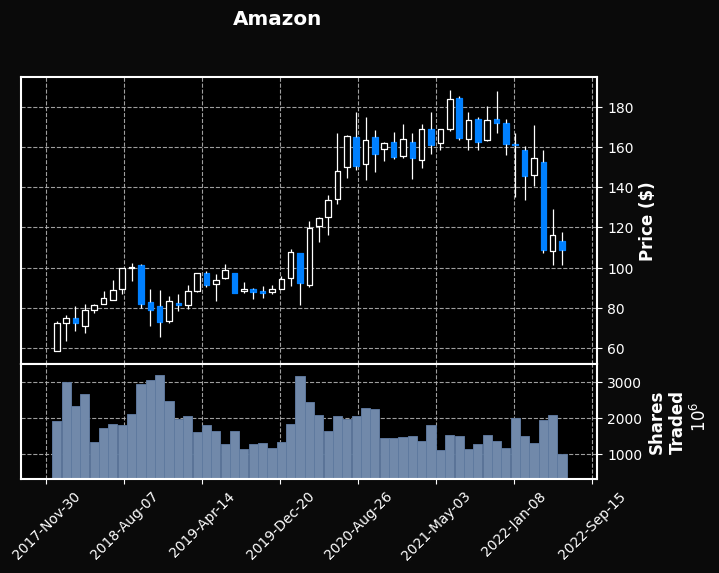

In [12]:
###
# Plots a candlestick chart according to the parameters
# Parameters:
# - data: the dataset to plot
# - volume: Bool to determine if secondary chart is plotted below main candlestick chart
# - show_nontrading: Bool to determine if NaN days are shown
# - title: String for the title of the chart
# - n_days: How many days each candlestick represents, default is 1
###

def plot_candlestick_chart(data, volume, show_nontrading, title, n_days=1):
    new_data = aggregate_data(data, n_days)

    flpt.plot(
        new_data,
        type="candle", # Type of chart
        volume=volume,
        show_nontrading=show_nontrading,
        title=title,
        style="mike", # Visual style of chart
        ylabel='Price ($)', # Y candle chart Label
        ylabel_lower="Shares\nTraded" # Y secondary chart label
    )

plot_candlestick_chart(train_data, True, True, "Amazon", 30)


### Boxplot
(using pyplot from BQ)

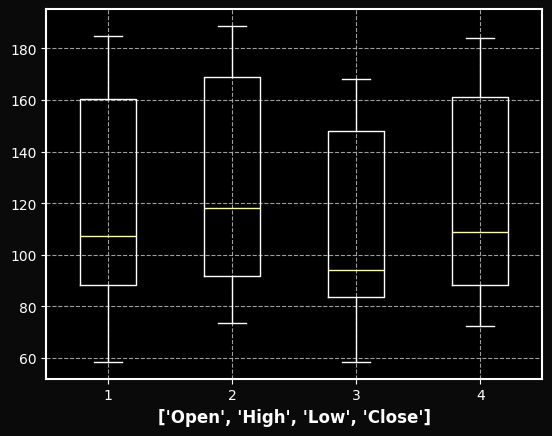

In [21]:
###
# Plots a boxplot chart according to the parameters
# Parameters:
# - data: pandas dataframe, the dataset to plot
# - features: Each feature to be plotted as a string in a list
# - n_days: How many days each candlestick represents, default is 1
###

### Why not just do all features?
# If we do, the volume values dwarf the other values
# Therefore we should only do it for the non volume features
# Scaling them is also typically not good for box plots

def plot_boxplot_chart(data, features, n_days=1):
    new_data = aggregate_data(data, n_days)

    # Extract the data for the selected features
    box_data = [new_data[feature] for feature in features]

    # Create figure
    fig = plt.figure()

    # Create box plots for each feature
    plt.boxplot(box_data)

    # X axis labelss
    plt.xlabel(features)

    # Show the chart
    plt.show()

plot_boxplot_chart(train_data,["Open", "High", "Low", "Close"], 30)